In [1]:
import pandas as pd
import numpy as np
import micplot 
import matplotlib.pyplot as plt

In [2]:
#config cell

FIFA_RANKING = {'België': 1,
 'Frankrijk': 2,
 'Engeland': 4,
 'Portugal': 5,
 'Spanje': 6,
 'Italië': 7,
 'Denemarken': 10,
 'Duitsland': 12,
 'Zwitserland': 13,
 'Kroatië': 14,
 'Nederland': 16,
 'Wales': 17,
 'Zweden': 18,
 'Polen': 21,
 'Oostenrijk': 23,
 'Oekraïne': 24,
 'Servië': 25,
 'Turkije': 29,
 'Slowakije': 36,
 'Hongarije': 37,
 'Rusland': 38,
 'Tsjechië': 40,
 'Noorwegen': 42,
 'Roemenië': 43,
 'Schotland': 44,
 'Ierland': 47,
 'Noord-Ierland': 48,
 'Griekenland': 51,
 'Ijsland': 52,
 'Finland': 54,
 'Bosnië-Hercegovina': 55,
 'Noord-Macedonië': 62,
 'Slovenië': 63,
 'Montenegro': 64,
 'Albanië': 66,
 'Bulgarije': 71,
 'Israel': 85,
 'Belarus': 89,
 'Armenië': 90,
 'Georgië': 91,
 'Luxemburg': 96,
 'Cyprus': 97,
 'Azerbeidjan': 110,
 'Faroer eilanden': 113,
 'Estland': 116,
 'Kosovo': 120,
 'Kazachstan': 124,
 'Litouwen': 134,
 'Letland': 138,
 'Andorra': 158}

PLAYERIDS = {
    'DummyClassifier': 121338,
    'GerW': 69504,
    'Moncef': 113174,
    'semjansen': 69968,
    'Lisanne123': 95376,
    'maryse_ajax': 109196,
    'HelderziendeMark': 96571,
    'crazy_bones_tm': 111985,
    'Kanye2024': 117015,
    'RensLokerse': 111878,
    'SjoerdCor': 91499,
    'BelgieEKWinnaar': 93118,
    'tby': 137331,
    
}

POOL_ID = 6808
URL_UITSLAGEN = 'https://www.ekpooltjes.nl/fixtures/'

## Data collection and preparation

In [3]:
def read(url, **kwargs):
    return pd.read_html(url, **kwargs)[0]


def clean_uitslagen(df):
    df = (df.loc[lambda df: df.nunique('columns').gt(4)]  # Drops header rows which has "groepswedstrijden 5 times" - leaves only match rows
          
          .set_axis(['WedstrijdNr','TeamThuis', 'TeamUit', 'Datum', 'Tijd', 'Score'], 'columns')
          .assign(WedstrijdNr = lambda df: pd.to_numeric(df['WedstrijdNr']))
          .set_index('WedstrijdNr')
         )  
    return df

    
def calculate_round(df):
    r = (df.reset_index() # Melt, keeping wedstrijd nr
         .melt(id_vars=['WedstrijdNr'], value_vars=['TeamThuis', 'TeamUit'])
         .set_index('WedstrijdNr')
         .sort_index()
         .groupby(['value']).transform('cumcount').add(1) 
        )
    assert r.groupby('WedstrijdNr').nunique().eq(1).all(), 'Differing rounds for one match!'
    return r.groupby('WedstrijdNr').min()



def create_poule_dict(table):
    standing = table.iloc[:4, 0]
    countries = standing.str.strip('*').str.strip().values
    poule = standing.name.split(' ')[1]
    dct = {c: poule for c in countries}
    return dct

def read_poule_indeling():
    url = 'https://www.ek2020-voetbal.nl/poules-ek-2020/'
    tables = pd.read_html(url)
    total = {}
    for table in tables:
        poule = create_poule_dict(table)
        total = {**total, **poule}
    return total





def calculate_features(df):
    poule_indeling = read_poule_indeling()

    df = df.assign(Round = lambda df: calculate_round(df),
                   Poule = lambda df: np.where(df['Round'].le(3), df['TeamThuis'].map(poule_indeling), np.nan)
                  )
    return df
    
df = read(URL_UITSLAGEN).pipe(clean_uitslagen).pipe(calculate_features)

In [4]:
def predict_fifa_based(home_team, away_team):
    try:
        home_fifa_rank = FIFA_RANKING[home_team]
        away_fifa_rank = FIFA_RANKING[away_team]
    except KeyError:
        return None
    
    if home_fifa_rank < away_fifa_rank:
        return '2 - 0'
    return '0 - 2'

def predict_dummy():
    return '2 -  0'

def predict_mode(predictions):
    return predictions.mode('columns')[0]

In [5]:
def create_predictions_url(name):
    
    player_id = PLAYERIDS[name]
    # While this is pool specific, this url with anyone's predictions is still available without a password
    url = f'https://www.ekpooltjes.nl/prediction/{player_id}/{POOL_ID}/'  
    return url

def read_predictions(name):
    player_url = create_predictions_url(name)
    return read(player_url, na_values='-')

def clean_predictions(df, name):
    df = (df.set_axis(['TeamThuis', 'TeamUit', 'Prediction', 'Uitslag', 'Punten'], 'columns')
          .loc[lambda df: df.nunique('columns').gt(1)]  # Drops header rows which has "groepswedstrijden" 5 times - leaves only match rows
          .set_index(pd.RangeIndex(start=1, stop=52, name='WedstrijdNr'))
          .drop(columns=['Uitslag', 'TeamThuis', 'TeamUit', 'Punten']) # from other df and self calculated
          .rename(columns={'Prediction': f'Prediction_{name}'})
         )  
    return df

def create_predictions_df():
    return pd.concat([read_predictions(name).pipe(clean_predictions, name) for name in PLAYERIDS.keys()], axis='columns')

def add_dummy_predictions(df, fixtures):
    df = df.assign(DummyPredictionFIFA = lambda df: [predict_fifa_based(*fixtures.loc[matchid, ['TeamThuis', 'TeamUit']]) for matchid in df.index],
                   DummyPredictionAlways2_0 = lambda df: predict_dummy(),
                   DummyPredictionMode = lambda df: predict_mode(df),
                   )
    return df
    

predictions = create_predictions_df().pipe(add_dummy_predictions, fixtures=df)

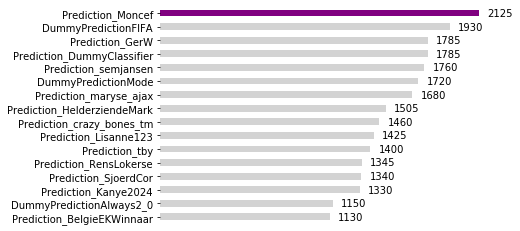

In [6]:
def score_predictions(true_scores, predictions):
    return [score_ekpooltjes_points(true_score, prediction) for true_score, prediction in zip(true_scores, predictions)]

def score_to_goals(score):
    try:
        goals = score.replace(' ', '').split('-')
    except AttributeError:
        return (np.nan, np.nan)
    return int(goals[0]), int(goals[1])

def score_ekpooltjes_points(true_score, predicted_score):
    if isinstance(predicted_score, float) and np.isnan(predicted_score): # must check type first because isnan only works for floats
        return 0
    
    true_goals = score_to_goals(true_score)
    predicted_goals = score_to_goals(predicted_score)
    if true_goals == predicted_goals:
        return 200
    
    true_goals_home, true_goals_away = true_goals
    predicted_goals_home, predicted_goals_away = predicted_goals
    
    predicted_right_winner = ((predicted_goals_home > predicted_goals_away) and (true_goals_home > true_goals_away)
                             or (predicted_goals_home < predicted_goals_away) and (true_goals_home < true_goals_away)
                             )
    predicted_right_draw = (predicted_goals_home == predicted_goals_away) and (true_goals_home == true_goals_away)
    
    predicted_right_n_goals_home = predicted_goals_home == true_goals_home
    predicted_right_n_goals_away = predicted_goals_away == true_goals_away
    
    points = (predicted_right_winner * 75 
             + predicted_right_draw * 100 
             + predicted_right_n_goals_home * 20
             + predicted_right_n_goals_away * 20)
    return points
    
def calculate_scored_points_per_game(predictions, true_score):
    df = predictions.join(true_score).dropna(subset=[true_score.name]).drop(columns=[true_score.name])
    return df.apply(lambda col: score_predictions(true_score, col))

points_per_game = calculate_scored_points_per_game(predictions, df['Score'])
standing = points_per_game.sum().sort_values(ascending=False)
micplot.visualize(standing)
plt.show()

Als referentie zijn 3 DummyPredictions aan de pool toegevoegd:
* DummyPredictionFIFA: Het land met de hoogste FIFA-ranking wint met 2-0
* DummyPredictionMode: De meest gekozen voorspelling van de Spot-onners
* DummyPredictionAlways2_0: Elke wedstrijd wordt 2-0, houdt geen rekening met welke landen spelen

Zo ver nog geen verrassingen: Moncef heeft ruimschoots de leiding en houdt als enige de DummyPrediction van de FIFA-ranking volgen achter zich: #successenvieren

## De stand ontleed
Maar ~~Parijs~~ Londen is nog ver; het gaat niet alleen om de huidige stand, maar ook wat we kunnen verwachten voor de toekomst. Worden er meer of minder punten gescoord?

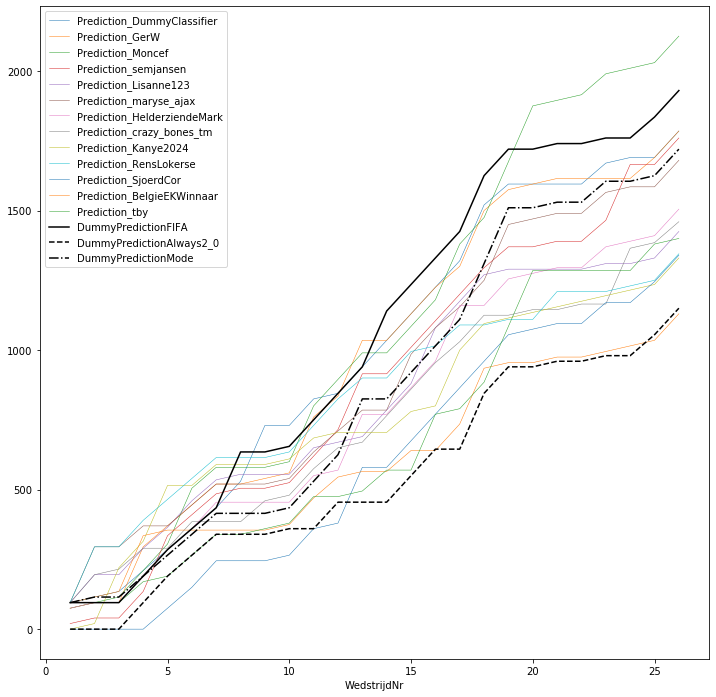

In [7]:
ax = points_per_game.filter(regex='^(?!DummyPrediction)').cumsum().plot(figsize=(12,12), linewidth=0.5)
points_per_game.filter(like='DummyPrediction').cumsum().plot(figsize=(12,12),style=['k-', 'k--', 'k-.'], ax=ax)
plt.show()

### Gemiddeld genomen voorspellen we steeds beter
Goed nieuws: gemiddeld genomen hebben we in de tweede wedstrijdronde 87.5 punten méér gescoord dan in de eerste wedstrijd ronde. Opvallend is dat die groei ook meer is dan de DummyPredictions, dus wij zijn echt een #lerendeorganisatie.


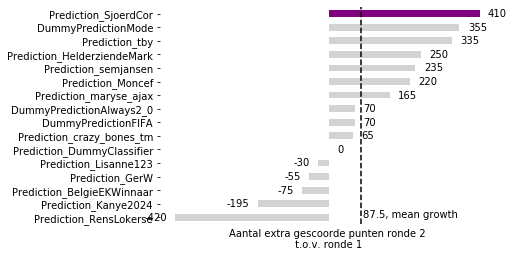

In [8]:
data = (points_per_game.join(df)
        .groupby('Round').sum()
        .transpose()  # micplot.visualize takes columns as values, and index 
        .assign(Growth = lambda df: df[2].sub(df[1]))
        ['Growth']
       )

vis = micplot.visualize(data)
mean_growth = data.mean()
vis.ax.axvline(mean_growth, c='k', ls='--')
vis.ax.annotate(f'{mean_growth}, mean growth', (mean_growth, 0), (mean_growth*1.05, 0))
vis.ax.set_xlabel('Aantal extra gescoorde punten ronde 2\n t.o.v. ronde 1')
plt.show()

## Overeenkomsten: wie voorspellen altijd hetzelfde?
Er zijn meerdere manieren om te bepalen wie vaak dezelfde voorspelling doen, omdat er meerdere maten van overeenkomst zijn:
* Het percentage dat je exact dezelfde score voorspelt - simpel, maar als de één 2-0 voorspelt en de ander 3-0, lijkt dat meer op elkaar dan 2-0 en 1-4
* De correlatie tussen het aantal gescoorde punten - iets gevoeliger voor wie wanneer goed voorspelt, maar je kunt er op verschillende manieren naast zitten (bv: de uitslag is 1-1, de een voorspelt 2-0 en de ander 2-3 maakt dat voor de correlatie niet uit)
* De "MutualScore": het aantal punten volgens de puntentelling van ekpooltjes.nl als je doet alsof de ene de echte uitslag is en de ander de voorspelde; neemt mooi aantal gescoorde doelpunten en uitslag ook mee

In [9]:
pred_long = predictions.reset_index().melt(id_vars=['WedstrijdNr'], var_name='Voorspeller', value_name='Voorspelling')
preds_compared = pred_long.merge(pred_long, on=['WedstrijdNr']).query('Voorspeller_x > Voorspeller_y')

def add_correlation_measures(df):
    df = df.assign(GelijkeVoorspelling = lambda df: df['Voorspelling_x'] == df['Voorspelling_y'],
                      MutualScore = lambda df: score_predictions(df['Voorspelling_x'], df['Voorspelling_y'])
                     )
    return df
overeenkomst = (preds_compared.pipe(add_correlation_measures)
                .groupby(['Voorspeller_x', 'Voorspeller_y']).mean())


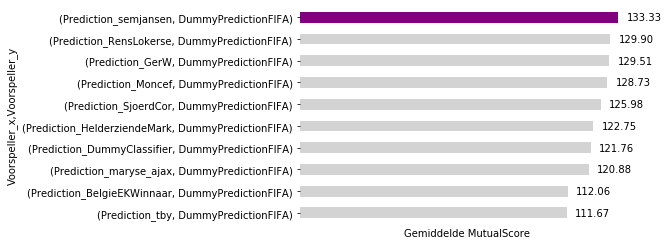

In [10]:
vis = overeenkomst['MutualScore'].nlargest(10).pipe(micplot.visualize)
vis.ax.set_xlabel('Gemiddelde MutualScore')
plt.show()

Het blijkt dat vooral het veel voorspellingen het eens zijn met de dummyvoorspelling op basis van de FIFA-ranglijst. Opvallend is dan wel weer dat de meeste hiervan blijkbaar net niet de goede aanpassingen doen aan deze voorspelling

In [11]:
overeenkomst_no_dummies = overeenkomst.reset_index().loc[lambda df: ~df[['Voorspeller_x', 'Voorspeller_y']].apply(lambda col: col.str.startswith('DummyPrediction')).any('columns')].set_index(['Voorspeller_x', 'Voorspeller_y'])

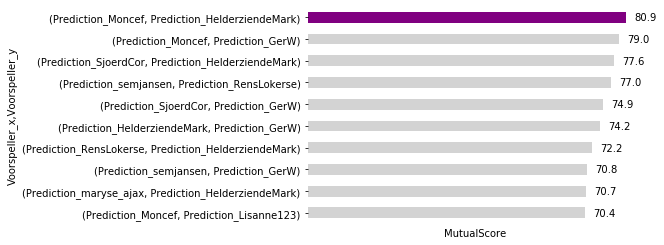

In [12]:
overeenkomst_no_dummies['MutualScore'].nlargest(10).pipe(micplot.visualize, strfmt='.1f')
plt.show()

Als we alleen kijken naar de spotonners, zien we dat Moncef en Mark, Moncef en Ger, en Sjoerd en Mark het meest eens zijn

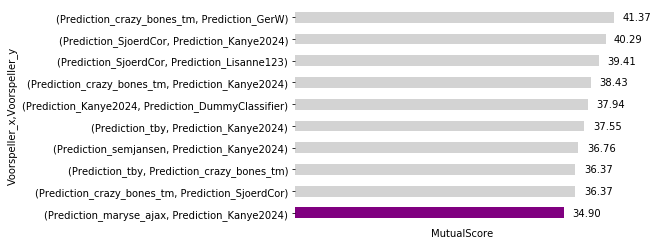

In [13]:
overeenkomst_no_dummies['MutualScore'].nsmallest(10).pipe(micplot.visualize, highlight=0)
plt.show()

Maryse en Kanye2024 zijn het minst eens

### Correlaties
Sjoerd hoort vaak bij de massa; en haalt ook vaak ongeveer even veel punten als Mark

In [14]:
corrs = points_per_game.corr().reset_index().melt(id_vars=['index']).query('index > variable').dropna().set_index(['index', 'variable'])['value'].sort_values(ascending=False)
display(corrs.loc[lambda s: s.gt(0.5)].to_frame())

value
index                       variable                             
Prediction_SjoerdCor        DummyPredictionMode          0.767788
                            Prediction_HelderziendeMark  0.752315
Prediction_GerW             DummyPredictionMode          0.750822
                            Prediction_BelgieEKWinnaar   0.701119
Prediction_HelderziendeMark DummyPredictionMode          0.627609
Prediction_SjoerdCor        Prediction_GerW              0.623914
Prediction_semjansen        Prediction_HelderziendeMark  0.605687
Prediction_maryse_ajax      DummyPredictionMode          0.605237
Prediction_Moncef           Prediction_HelderziendeMark  0.600825
DummyPredictionMode         DummyPredictionAlways2_0     0.578556
Prediction_semjansen        Prediction_SjoerdCor         0.575880
Prediction_maryse_ajax      Prediction_RensLokerse       0.561637
Prediction_Moncef           DummyPredictionMode          0.561253
Prediction_HelderziendeMark Prediction_GerW              0.552349
Prediction_semjansen        DummyPredictionMode          0.547303
Prediction_DummyClassifier  DummyPredictionFIFA          0.535589
Prediction_tby              Prediction_Moncef            0.532331
Prediction_GerW             DummyPredictionAlways2_0     0.521145
Prediction_SjoerdCor        Prediction_Moncef            0.512134
Prediction_BelgieEKWinnaar  DummyPredictionAlways2_0     0.509907

In [15]:
def order_score(score):
    goals = score_to_goals(score)
    
    return f'{max(goals)} - {min(goals)}'

In [16]:
def recalculate_scores(scores):
    df = (pd.DataFrame([score_to_goals(p) for p in scores], index=predictions.index)
         .assign(
                 TotalGoals = lambda df: df.sum('columns', skipna=False),
                 Margin = lambda df: df[0].sub(df[1]).abs(),
                 Winner = lambda df: df[0] != df[1],
                 Uitslag = lambda df: [order_score(score) for score in scores]
                )
          .rename({0: 'MinGoals', 1: 'MaxGoals'})
         )
    df.columns = pd.MultiIndex.from_product([[scores.name], df.columns])

    return df
    
    

In [17]:
prediction_characteristics = pd.concat([recalculate_scores(predictions[p]) for p in predictions] + [recalculate_scores(df['Score'])], axis='columns').swaplevel(axis=1)

## Waarom score we niet het optimale aantal punten?

### Spot-on voorspelt vaker dan de werkelijkheid gelijke spelen

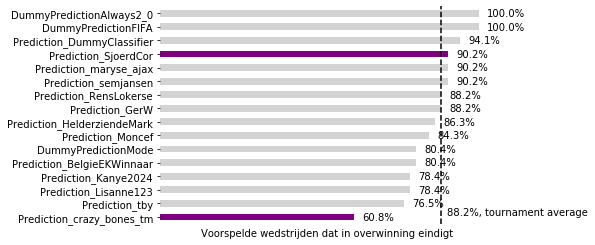

In [18]:
def plot_characteristics(prediction_characteristics, true_col='Score', **kwargs):
    characteristics = prediction_characteristics.copy()
    true_score = characteristics.pop(true_col)
    vis = characteristics.mean(skipna=True).pipe(micplot.micompanyify, **kwargs)
    tournament_mean = true_score.mean() 
    vis.ax.axvline(tournament_mean, c='k', ls='--')
    vis.ax.annotate('{:{prec}}, tournament average'.format(tournament_mean, prec=vis.strfmt), (tournament_mean, 0), (tournament_mean * 1.02, 0.1))
    return vis

vis = plot_characteristics(prediction_characteristics['Winner'],  highlight=[0, -4], strfmt='.1%')
vis.ax.set_xlabel('Voorspelde wedstrijden dat in overwinning eindigt')
plt.show()

In [19]:
prediction_characteristics['Winner'].mean().filter(like='Prediction').mean()

0.8541666666666667

Evenwichting en gebalanceerd als we zijn, voorspellen wij dat zo'n 15% van de wedstrijden in een gelijkspel eindigt (tot wel 40% voor crazy_bones_tm). In de werkelijkheid is dat tot nu toe minder dan 11.8%.

### Het gemiddeld aantal doelpunten per wedstrijd zit behoorlijk goed
Volgens de voorspellingen is dat gemiddeld 2.3, en dat matcht het toernooipercentage aardig. Vooral Sander wordt positief verrast door de aantrekkelijke uitslagen.

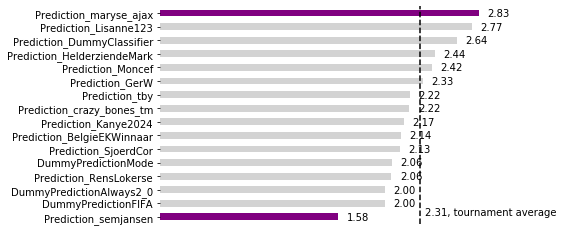

In [20]:
vis = plot_characteristics(prediction_characteristics['TotalGoals'],  highlight=[0, -1])

### Ook de marges zit behoorlijk goed
Qua marges zitten we iets hoger dan de werkelijkheid: wij voorspellen 1.4, terwijl in het toernooi het op 1.3 houdt. Ook hier zien we echter het hoge remisepercentage van crazy_bones_tm terug.

In [21]:
prediction_characteristics['Margin'].mean().mean()

1.420845744029135

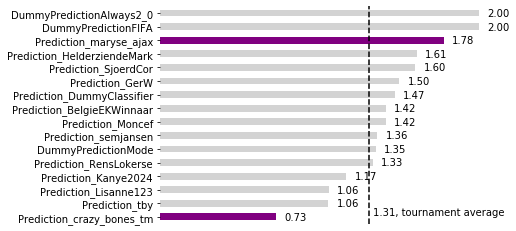

In [22]:
plot_characteristics(prediction_characteristics['Margin'],  highlight=[0, -3])
plt.show()

### Per poule
De eigen poule gaat ons by far het beste af; we scoren meer dan twee keer zoveel punten als in de poules van Engeland en Spanje

In [23]:
poule_scores = points_per_game.join(df).groupby('Poule').mean().drop(columns='Round')

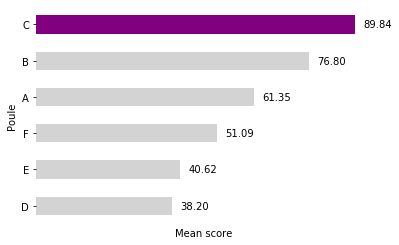

In [24]:
poule_avgs = poule_scores.mean(axis='columns')
vis = micplot.visualize(poule_avgs)
vis.ax.set_xlabel("Mean score")
plt.show()

In [25]:
poule_scores = poule_scores.div(poule_avgs, axis='index')#.drop('colu')

In [26]:
poule_scores.transpose().style.highlight_max()

Poule,A,B,C,D,E,F
Prediction_DummyClassifier,1.086587,0.927772,1.238261,1.112474,1.815385,0.929664
Prediction_GerW,0.977929,1.546287,1.238261,0.752556,0.707692,1.345566
Prediction_Moncef,0.828523,1.334690,1.293913,2.061350,1.476923,1.908257
Prediction_semjansen,0.624788,1.269583,0.946087,1.570552,1.815385,1.296636
Prediction_Lisanne123,1.358234,0.683622,1.293913,0.621677,0.123077,0.660550
Prediction_maryse_ajax,1.602716,0.732452,0.946087,0.261759,1.476923,1.198777
Prediction_HelderziendeMark,0.828523,1.611394,0.737391,0.883436,0.707692,0.929664
Prediction_crazy_bones_tm,1.303905,0.618515,0.793043,0.130879,1.815385,0.929664
Prediction_Kanye2024,0.570458,1.611394,0.528696,1.570552,0.369231,0.660550
Prediction_RensLokerse,1.371817,0.797558,0.473043,1.145194,0.369231,0.929664


Zo heeft ieder zijn eigen poule waarin hij/zij het  goed doet.  
Behalve Sjoerd. Die doet het in geen één poule beter dan het gemiddelde.